# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

## Exploring porfolio

In [4]:
portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


#### Question: How many offers are there?

In [5]:
portfolio.shape

(10, 6)

In [6]:
print('There are {} offers'.format(len(portfolio['id'].unique())))

There are 10 offers


Let's compute the validity from duration.

In [7]:
portfolio['validity'] = portfolio['duration'] * 24

In [8]:
print('There are {} unique validity times.'.format(portfolio['validity'].nunique()))

There are 5 unique validity times.


In [9]:
portfolio['validity'].unique()

array([168, 120,  96, 240,  72])

In [10]:
portfolio.groupby('offer_type').describe()

difficulty                                                \
                   count   mean       std  min   25%   50%   75%   max   
offer_type                                                               
bogo                 4.0   7.50  2.886751  5.0  5.00   7.5  10.0  10.0   
discount             4.0  11.75  5.678908  7.0  9.25  10.0  12.5  20.0   
informational        2.0   0.00  0.000000  0.0  0.00   0.0   0.0   0.0   

              duration       ...   reward       validity                    \
                 count mean  ...      75%   max    count   mean        std   
offer_type                   ...                                             
bogo               4.0  6.0  ...     10.0  10.0      4.0  144.0  27.712813   
discount           4.0  8.5  ...      3.5   5.0      4.0  204.0  41.569219   
informational      2.0  3.5  ...      0.0   0.0      2.0   84.0  16.970563   

                                                  
                 min    25%    50%    75%    max  
offer_type                                        
bogo           120.0  120.0  144.0  168.0  168.0  
discount       168.0  168.0  204.0  240.0  240.0  
informational   72.0   78.0   84.0   90.0   96.0  

[3 rows x 32 columns]

Looks like each offer type has its own validity. Let's print print out validity times for each offer type.

In [11]:
portfolio.groupby('offer_type')['validity'].unique()

offer_type
bogo             [168, 120]
discount         [240, 168]
informational      [96, 72]
Name: validity, dtype: object

In [12]:
portfolio.groupby('offer_type')['id'].nunique()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 4 bogo offers, 4 discount offers, and 2 informational offers.

## Exploring profile

In [13]:
profile.head(3)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


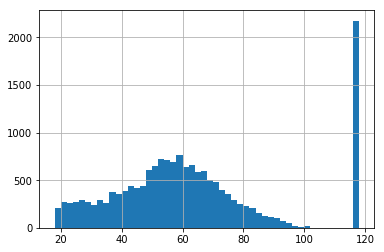

In [14]:
profile['age'].hist(bins=50)

It's interesting to see a large group of people that are 118 years old, because I don't expect Starbucks to have that many 118-year-old customers. This seems like an anomoly but it can also be real user input data or they're somehow targeted by the offers. Since we don't know for sure, it's better to keep this data and see what we find.

We can try putting people in age groups.

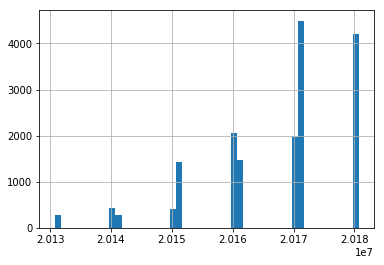

In [15]:
profile['became_member_on'].hist(bins=50)

There's an increase number of users over the year. Not sure yet if this information is useful for what we're about to do.

In [16]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

There are missing values. We should mark them as unspecified.

See gender distribution

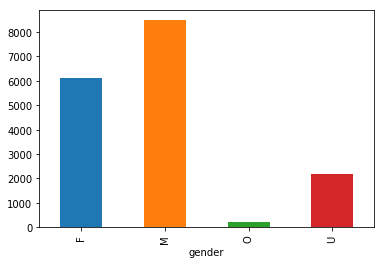

In [17]:
profile[['gender', 'id']].fillna('U').groupby('gender')['id'].count().plot.bar()

See income distribution

In [18]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Min income is \\$30K, max is \\$120K and median is \\$64K.

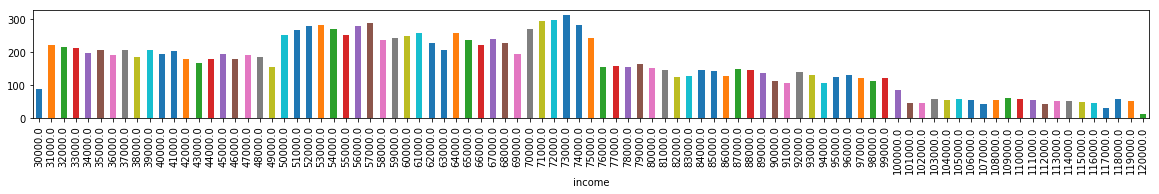

In [19]:
plot = profile.groupby('income')['id'].count().plot.bar(figsize=(20,2))


In [20]:
profile.groupby('income')['id'].count().reset_index().sort_values('id', ascending=False).head(10)

,income,id
43,73000.0,314
42,72000.0,297
41,71000.0,294
27,57000.0,288
44,74000.0,282
23,53000.0,282
26,56000.0,281
22,52000.0,281
24,54000.0,272
40,70000.0,270


There are more people with mid-level incomes (\\$50K-\\$75K) and tails off as income increases. There aren't a lot of people having income of \\$120K vs \\$50K.

Also note that income values are collected in increment of \\$1K. We should group this in increments of \\$10K.

See income distribution by age

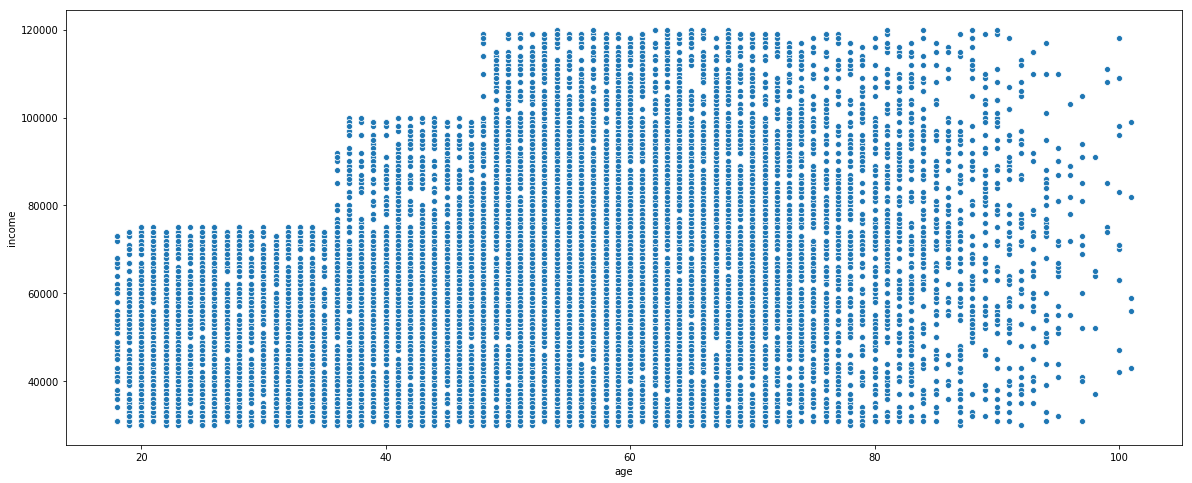

In [21]:
fig, ax = plt.subplots(figsize=(20,8))
sns.scatterplot(x="age", y="income", data=profile)

While there is various income levels for every age, there is an upper limit that changes in steps as age increases.
    
    *Age*            *Income Limit*
    36 or younger    $78K
37-50            $100K
    51 or older      $120K
    
The plot is less dense when income is highest. There are fewer high earners than low earners.


In [22]:
print('There are {} users'.format(profile['id'].nunique()))

There are 17000 users


## Exploring transcript

In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Note: Fields in the value column should be extracted out.

In [24]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Let's take a look and see how many receive events there are


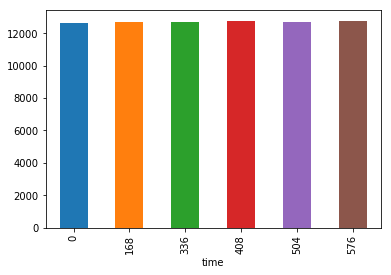

In [25]:
transcript[transcript['event'] == 'offer received'].groupby('time')['event'].count().plot.bar()

I'm going call an event a campaign since event is a column name. So it looks like there are six campaigns, each is 168 hours apart. That is, offers were sent out times in this dataset.

In [26]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [27]:
transcript_group = transcript.groupby('event')

In [28]:
transcript_group['time'].unique()

event
offer completed    [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...
offer received                          [0, 168, 336, 408, 504, 576]
offer viewed       [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...
transaction        [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...
Name: time, dtype: object

In [29]:
transcript_group['person'].count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [30]:
transcript[transcript['event'] == 'offer received'].groupby('time')['person'].nunique()

time
0      12650
168    12669
336    12711
408    12778
504    12704
576    12765
Name: person, dtype: int64

Out of 17k users, about 12.7K receive offers during each campaign.

# Cleaning & Transformation

## Cleaning & Transforming Portfolio


In [31]:
portfolio.head(3)

,channels,difficulty,duration,id,offer_type,reward,validity
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,168
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,120
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,96


In [32]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

## Cleaning & Transforming Profile

In [33]:
# Checking for NAs and handling them
profile.isna().sum()


age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There are missing values for gender and income. It's about 13% of the population. 
We can consider drop these later if they affect our learning.

For now, let's fill missing gender values with 'U' for unspecified/unidentified.

Fill missing income values with average income from people in the same age group.

In [34]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

We have 18 year olds to 118 year olds. Median age is 58.


In [35]:
profile['gender'].fillna('U', inplace=True)

In [36]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [37]:
profile.head(2)

,age,became_member_on,gender,id,income
0,118,20170212,U,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [38]:
# Fill missing income with average by age
avg_incomes = profile.groupby('age', sort=True)['income'].mean().reset_index().rename(columns={'income': 'avg_income'})


In [39]:
avg_incomes[avg_incomes['avg_income'].isna()]

,age,avg_income
84,118,NaN


It could be possible that customers who said they are 118 years old are giving a fictitious age and not provide an income. It's also possible that they are real customers, so we'll try our best to impute their income by filling forward.

In [40]:
# if average income is missing, fillforward
avg_incomes.fillna(method='ffill', inplace=True)
profile = profile.merge(avg_incomes, on='age', how='left')
profile['income'].fillna(profile['avg_income'], inplace=True)

In [41]:
profile.head()

,age,became_member_on,gender,id,income,avg_income
0,118,20170212,U,68be06ca386d4c31939f3a4f0e3dd783,67800.0,67800.000000
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,71105.714286
2,118,20180712,U,38fe809add3b4fcf9315a9694bb96ff5,67800.0,67800.000000
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,71666.666667
4,118,20170804,U,a03223e636434f42ac4c3df47e8bac43,67800.0,67800.000000


#### Creating age groups
We'll use the range from [Age Demographics in Survey Research blog](https://community.verint.com/b/customer-engagement/posts/age-demographics-in-survey-research) as guidance. However, we should adapt this range suited for our data. As noted, there are a lot of people who are 118 year olds. That seems like an outlier so we should extend the range in a way that put those people in their own group. We also don't have anyone younger than 18.

We'll define the following age groups: 

    18 to 21
    22 to 34
    35 to 44
    45 to 54
    55 to 64
    65 to 74
    75 to 84
    85 to 94
    95 to 104
    105 to 114
    115 to 118
    
Furthermore, we'll convert these ranges into numerical values. It might be helpful for any machine learning algorithms we're going to use later to have numerical values as an input option. We'll call these numerical values bracket.

    *age group*     *bracket*
    18 to 21        18
    22 to 34        22
    35 to 44        35
    45 to 54        45
    55 to 64        55
    65 to 74        65
    75 to 84        75
    85 to 94        85
    95 to 104       95
    105 to 114      105
    115 to 118      115


In [42]:
def get_age_bracket(age): 
    if (age <= 21):
        return 18
    elif (age >=22 and age <= 34):
        return 22
    elif (age >=35 and age <= 44):
        return 35
    elif (age >=45 and age <= 54):
        return 45
    elif (age >=55 and age <= 64):
        return 55
    elif (age >=65 and age <= 74):
        return 65
    elif (age >=75 and age <= 84):
        return 75
    elif (age >=85 and age <= 94):
        return 85
    elif (age >=95 and age <= 104):
        return 95
    elif (age >=105 and age <= 114):
        return 105
    else:
        return 115


In [43]:
profile['age_bracket'] = profile['age'].apply(get_age_bracket)

#### Creating income brackets
Similar to age bracket, we'll put incomes into bracket of \\$10K increments. That is, we'll have \\$30K, \\$40K, \\$50K and so on.


In [44]:
def get_income_bracket(income):
    if income < 40000:
        return 30000
    elif income < 50000:
        return 40000
    elif income < 60000:
        return 50000
    elif income < 70000:
        return 60000
    elif income < 80000:
        return 70000
    elif income < 90000:
        return 80000
    elif income < 100000:
        return 90000
    elif income < 110000:
        return 100000
    elif income < 120000:
        return 110000
    else:
        return 120000

In [45]:
profile['income_bracket'] = profile['income'].apply(get_income_bracket)

## Cleaning & Transforming transcript

In [46]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


### Explode the json values into their own columns

In [47]:
from pandas.io.json import json_normalize
clean_transcript = transcript.join(json_normalize(transcript['value']))
clean_transcript['offer_id'].fillna(clean_transcript['offer id'], inplace=True)
clean_transcript.drop(['offer id', 'value'], inplace=True, axis=1)

In [48]:
clean_transcript.head(2)

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [49]:
clean_transcript['amount'] = clean_transcript['amount'].fillna(0)
clean_transcript['reward'] = clean_transcript['reward'].fillna(0)

# Further Exploration & Transformation

### Now that we have new columns let's explore a little further and ask meaningful questions.

#### Question: How many offers can a person receive?

In [50]:
print('A person can receive the same offers up to {} times'.format(
    clean_transcript[clean_transcript['event'] == 'offer received'].groupby(['person', 'offer_id'])['offer_id'].count().max()
))

A person can receive the same offers up to 5 times


#### Question: How many times can a person receive an offer per campaign (recall we define each offer receive event as one campaign)?

In [51]:
tmp = clean_transcript.merge(portfolio, how='left', on='offer_id')
tmp[
    (tmp['event'] == 'offer received')
].groupby(['time', 'person', 'offer_id']).count().max()

event         1
amount        1
reward_x      1
channels      1
difficulty    1
duration      1
offer_type    1
reward_y      1
validity      1
dtype: int64

With a max of 1, a person receive one offer per campaign

In [52]:
clean_transcript[clean_transcript['event'] == 'offer received'].groupby('time')['offer_id'].nunique()

time
0      10
168    10
336    10
408    10
504    10
576    10
Name: offer_id, dtype: int64

All ten offers were sent out in each campaign. In othe words, in each campaign, there are ten different offers.

#### Question: What does receive/view/complete offer events and transaction events look like?

In [53]:
clean_transcript[clean_transcript['event'] == 'offer received'].head(2)

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0


In [54]:
clean_transcript[clean_transcript['event'] == 'offer viewed'].head(2)

,event,person,time,amount,offer_id,reward
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,0.0,5a8bc65990b245e5a138643cd4eb9837,0.0


In [55]:
clean_transcript[clean_transcript['event'] == 'offer completed'].head(2)

,event,person,time,amount,offer_id,reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0.0,2906b810c7d4411798c6938adc9daaa5,2.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,2.0


In [56]:
clean_transcript[clean_transcript['event'] == 'transaction'].head(2)

,event,person,time,amount,offer_id,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,0.0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,0.0


NOTE: Transaction doesn't have offer id. Need to figure out how to associate it with an offer completed event.

#### Question: Transaction event doesn't have an offer_id, how can it be attributed to an offer completed event

In [57]:
clean_transcript[
    clean_transcript['person']=='fe97aa22dd3e48c8b143116a8403dd52'
]

,event,person,time,amount,offer_id,reward
107,offer received,fe97aa22dd3e48c8b143116a8403dd52,0,0.00,fafdcd668e3743c1bb461111dcafc2a4,0.0
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,0.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,0.00,fafdcd668e3743c1bb461111dcafc2a4,2.0
15578,offer viewed,fe97aa22dd3e48c8b143116a8403dd52,6,0.00,fafdcd668e3743c1bb461111dcafc2a4,0.0
24238,transaction,fe97aa22dd3e48c8b143116a8403dd52,30,13.90,NaN,0.0
38230,transaction,fe97aa22dd3e48c8b143116a8403dd52,84,16.99,NaN,0.0
39554,transaction,fe97aa22dd3e48c8b143116a8403dd52,90,13.96,NaN,0.0
53283,offer received,fe97aa22dd3e48c8b143116a8403dd52,168,0.00,3f207df678b143eea3cee63160fa8bed,0.0
79443,offer viewed,fe97aa22dd3e48c8b143116a8403dd52,198,0.00,3f207df678b143eea3cee63160fa8bed,0.0
79444,transaction,fe97aa22dd3e48c8b143116a8403dd52,198,28.71,NaN,0.0


So, transaction and offer completed event share a common timestamp.

#### Question: How many events are there by type?

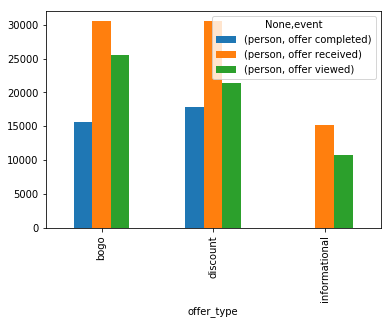

In [59]:
data = clean_transcript.merge(portfolio, how='left', on='offer_id')
pd.pivot_table(data, index=['offer_type'], columns=['event'], values=['person'], aggfunc=lambda x: len(x)).plot.bar()


NOTE: informational offer do not have completed event. We need to somehow determine its influence.

My understanding is that an informational offer is like an advertisement, when it is received, it is viewed. Presumbly because it doesn't have any reward, there isn't an offer completed event for it. 

We can supplement the our own offer reviewed and offer completed events for informational offer.

In [60]:
clean_transcript.shape

(306534, 6)

#### Question: Transaction event doesn't have an offer_id, how can it be attributed to a offer completed event

In [61]:
# For every informational offer receive event, create an informational view event.
tmp = clean_transcript[clean_transcript['event']=='offer received']
tmp = tmp.merge(portfolio, how='left', on='offer_id')
viewed_informational_offers = tmp[tmp['offer_type']=='informational'][['person', 'offer_id', 'time']]
viewed_informational_offers['event'] = 'offer viewed'
viewed_informational_offers['amount'] = 0.0
viewed_informational_offers['reward'] = 0.0
clean_transcript = pd.concat([clean_transcript, viewed_informational_offers])

/sdk/install/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [62]:
# For every transaction that is influenced by an informational offer, create a complete offer event for it
tmp = clean_transcript[clean_transcript['event']=='offer received'].merge(portfolio, how='left', on='offer_id')
info_received_times = tmp[tmp['offer_type'] == 'informational'].sort_values(['person', 'offer_id', 'time']).groupby(['person', 'offer_id'])['time'].apply(list)
info_received_times = info_received_times.reset_index()
info_received_times = info_received_times.merge(portfolio[['offer_id', 'validity']], how='left', on='offer_id')


def get_influenced_info_offer_id(x):
    """
        Look up to see if a transaction x is influenced by an informational offer.
        The transaction is influenced if it occurs between the receive time and expire time
        of the offer.
        If the person did receive an informational offer but was not influenced, return False, otherwise True.
        If the person did not receive an information offer, return None.
    """
    offers_df = info_received_times[info_received_times['person']== x['person']]
    for index, row in offers_df.iterrows():
        offer_id = row['offer_id']
        validity = row['validity']
        times = row['time']
        times = sorted(times, reverse=True)
        for receive_time in times:
            if (x['time'] > receive_time): # and (x['time'] <= (receive_time + validity)):
                return offer_id
    return None

In [63]:
completed_informational_offers = clean_transcript[clean_transcript['event']=='transaction']
completed_informational_offers['event'] = 'offer completed'
completed_informational_offers['offer_id'] = completed_informational_offers.apply(get_influenced_info_offer_id, axis=1)
completed_informational_offers = completed_informational_offers[completed_informational_offers['offer_id'].notna()]
clean_transcript = pd.concat([clean_transcript, completed_informational_offers])


/sdk/install/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/sdk/install/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Great, now our transcript data should have viewed and completed events for informational offers. Let's take a peak to make sure it's there.



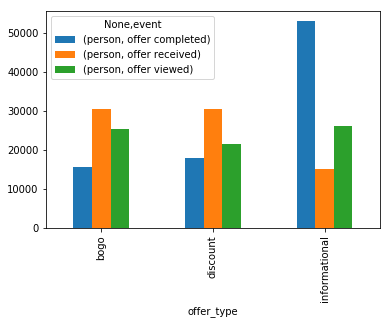

In [64]:
data = clean_transcript.merge(portfolio, how='left', on='offer_id')
pd.pivot_table(data, index=['offer_type'], columns=['event'], values=['person'], aggfunc=lambda x: len(x)).plot.bar()

From the transcript, we can separate the transcript log by event.

In [65]:
received_offers = clean_transcript[clean_transcript['event'] == 'offer received'][['person', 'offer_id', 'time']]
viewed_offers = clean_transcript[clean_transcript['event'] == 'offer viewed'][['person', 'offer_id', 'time']]
completed_offers = clean_transcript[clean_transcript['event'] == 'offer completed'][['person', 'offer_id', 'time', 'reward']]
transactions = clean_transcript[clean_transcript['event'] == 'transaction'][['person', 'time', 'amount']]

#### Question: Is it possible for a offer to be completed multiple times?

In [66]:
completed_offers.groupby(['person', 'offer_id', 'time'])['reward'].count().max()

3

Yes, seems like it's possible, up to 3 times in this dataset.

#### Question: How many offers are there that were completed multiple times at one instant in time?

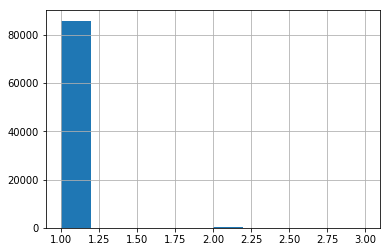

In [67]:
completed_offers.groupby(['person', 'offer_id', 'time'])['reward'].count().hist()

There are very few offers that were completed multiple times. 

Since it's possible that an offer can be completed more than once.
I'm thinking, for example, for a BOGO, a customer spend double the amount to get double the rewards.
Let's combine the reward for completed_offers, that way we don't have duplicate offer complete events for the same offer at any one instant in time.

In [68]:
completed_offers = completed_offers.groupby(['person', 'offer_id', 'time']).sum().reset_index()

#### Question: How many offers can be completed at the same time.


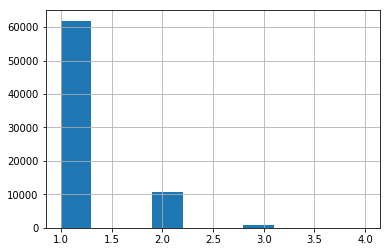

In [69]:
completed_offers.groupby(['person', 'time'])['offer_id'].count().hist()

There are some offers that are completed at the same time.
#### Question how is this possible if a person only receives an offer per campaign?

In [70]:
completed_offers.groupby(['person', 'time'])['offer_id'].count().sort_values(ascending=False).head(3)

person                            time
0d50a9abf52442e29e484474cc8d0d68  510     4
a23bb0212eac4e948223dfdd500c7822  618     4
0225045e245f4b7289cc55c0b5870ae2  588     4
Name: offer_id, dtype: int64

In [71]:
tmp = received_offers[received_offers['person']=='75bb371cf36d4a9186397a9866ed2fbe'].merge(portfolio, how='left', on='offer_id')
tmp['expire_time'] = tmp['time'] + tmp['validity']

In [72]:
tmp

,person,offer_id,time,channels,difficulty,duration,offer_type,reward,validity,expire_time
0,75bb371cf36d4a9186397a9866ed2fbe,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,"[web, email, mobile]",5,7,bogo,5,168,168
1,75bb371cf36d4a9186397a9866ed2fbe,f19421c1d4aa40978ebb69ca19b0e20d,168,"[web, email, mobile, social]",5,5,bogo,5,120,288
2,75bb371cf36d4a9186397a9866ed2fbe,0b1e1539f2cc45b7b9fa7c272da2e1d7,336,"[web, email]",20,10,discount,5,240,576
3,75bb371cf36d4a9186397a9866ed2fbe,2298d6c36e964ae4a3e7e9706d1fb8c2,408,"[web, email, mobile, social]",7,7,discount,3,168,576
4,75bb371cf36d4a9186397a9866ed2fbe,4d5c57ea9a6940dd891ad53e9dbe8da0,504,"[web, email, mobile, social]",10,5,bogo,10,120,624
5,75bb371cf36d4a9186397a9866ed2fbe,fafdcd668e3743c1bb461111dcafc2a4,576,"[web, email, mobile, social]",10,10,discount,2,240,816


Because the validity periods are not consistent and varies, it makes it possible for many offers to be active (not expired) and overlap each other.

This leads to many offers getting completed at the same time. This means one transaction can have multiple offer completes. One-to-many relationship.

This is like stacking multiple offers and completing them all in one transaction.

In this case, the transaction amount can be split to attribute equally to each offer. 
However, I have to argue that that one transaction
is influenced by all the offers and therefore that transaction needs to attribute to all the offers it completes. So instead of splitting, we can simplify the attribution a little and attribute the entire transaction to each completed offer. Furthermore, there are only few transactions that can be attributed to multiple offers anyway, it shouldn't affect our analysis.

# Observation

With the initial data exploration, note the following observation:

Recall that the validity max is 240 hours. It's possible for someone receive an offer in one campaign 
and complete an offer in another campaign. This seems to be the case with 'discount' offers.


# Construct a transaction dataframe

Now that the data is cleaned up and transformed. Let's construct a dataframe of all transactions along with the offer information, i.e. whether an offer was received, viewed and completed. 

Above, we have separaed the transcript data into dataframes by event: received_offers, viewed_offers, completed_offers.
We need to merge them into one dataframe and then link them to the transaction they complete.

As observed in the data exploration, offers were sent out six distinct times in six different campaigns. That means that there are only six receive_time. viewed_offers dataframe and completed_offers dataframe don't have receive_time. We need to impute it.

### First, let's join received_offers with portfolio to get the details about each offers. 

In [73]:
received_offers.head(2)

,person,offer_id,time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0


In [74]:
received_offers = received_offers.merge(portfolio, how='left', on='offer_id')
received_offers['time_expire'] = received_offers['time'] + received_offers['validity']
received_offers['receive_time'] = received_offers['time']
received_offers = received_offers.drop('time', axis=1)


In [75]:
received_offers.head(2)

,person,offer_id,channels,difficulty,duration,offer_type,reward,validity,time_expire,receive_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,168,168,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,discount,5,240,240,0


### Construct a dataframe that shows whether or not a received offer has been viewed

Start with the viewed offers and work backword to get the received time. We know that offers were sent six times, we need to figure out when the offers were received each viewed offer. That is, we need to populate the `receive_time` column for the `viewed_offers` dataframe.

In [76]:
# For each person/offer create a list of receive times
receive_times = received_offers.sort_values(['person', 'offer_id', 'receive_time']).groupby(['person', 'offer_id'])['receive_time'].apply(list)

In [77]:
def get_time_received(x):
    """
        Look up the receive time for event x
    """
    if receive_times.index.contains((x['person'], x['offer_id'])):
        times = receive_times.loc[x['person'], x['offer_id']]
        times = sorted(times, reverse=True)

        for receive_time in times:
            if (receive_time <= x['time']):
                return receive_time
    return None


In [78]:
# Populate viewed_offers dataframe with receive_time.        
viewed_offers['receive_time'] = viewed_offers.apply(get_time_received, axis=1)
viewed_offers['view_time'] = viewed_offers['time']
viewed_offers = viewed_offers.drop('time', axis=1)

In [79]:
# Validate to make sure nothing was missed.
viewed_offers['receive_time'].isna().sum()

0

Likewise, we need to populate `receive_time` column for `completed_offers` dataframe.

In [80]:
# Populate completed_offers dataframe with receive_time.
completed_offers['receive_time'] = completed_offers.apply(get_time_received, axis=1)
completed_offers['complete_time'] = completed_offers['time']
completed_offers = completed_offers.drop('time', axis=1)


In [81]:
# Validate to make sure we got everything.
completed_offers['receive_time'].isna().sum()

0

In [82]:
transactions.shape

(138953, 3)

In [83]:
# Populate transactions with completed events.
# Here, we need to match transaction time with complete_time
transactions = transactions.merge(completed_offers, how='left', left_on=['person', 'time'], right_on=['person', 'complete_time'])


In [84]:
transactions.shape

(151586, 7)

There are more rows after the merge. This is expected as we observed that one transaction can generate multiple offer completed events because it can satisfy multiple offers at once.

In [85]:
# Now that we have transactions and their corresponding offer completed events, let's continue merging. 
# Let's merge in when offers were veiwed.
transactions = transactions.merge(viewed_offers, how='left', on=['person', 'offer_id', 'receive_time'])

In [86]:
# Merge into receive events
transactions = transactions.merge(received_offers, how='left', on=['person', 'offer_id', 'receive_time'])

In [87]:
transactions.shape

(189801, 15)

In [88]:
transactions.columns

Index(['person', 'time', 'amount', 'offer_id', 'reward_x', 'receive_time',
       'complete_time', 'view_time', 'channels', 'difficulty', 'duration',
       'offer_type', 'reward_y', 'validity', 'time_expire'],
      dtype='object')

In [89]:
transactions['reward'] = transactions['reward_x']
transactions = transactions.drop(['reward_x', 'reward_y'], axis=1)

In [90]:
transactions = transactions[
    ['person', 'time', 'amount', 'offer_id', 'receive_time',
       'view_time', 'complete_time', 'time_expire',
      'channels', 'difficulty', 'duration',
       'offer_type', 'reward', 'validity']
]

In [91]:
transactions.head(2)

,person,time,amount,offer_id,receive_time,view_time,complete_time,time_expire,channels,difficulty,duration,offer_type,reward,validity
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0.0,168.0,"[web, email, mobile]",10.0,7.0,discount,2.0,168.0


If the transaction completes an offer, we can create a column to determine whether or not the purchased was influenced. Recall that users do not opt-in to these offers and they can complete an offer without viewing it. If a person viewed and completed an offer, the transaction was influenced. If a person did not view and complete an offer, the transaction was NOT influenced.

Create a column `influenced_by_bogo` to denote if a transaction was influenced by a bogo offer.
Create a column `influenced_by_discount` to denote if a transaction was influenced by a discount offer.
Create a column `influenced_by_informational` to denote if a transaction was influenced by a informational offer.

In [702]:
def is_influenced(offer_type, x):
    """
        If transaction x is influenced by offer_type then return True, otherwise, False.
        If transaction x did not receive offer of offer_type, then return None. 
    """
    if x['offer_type'] == offer_type:
        return (x['view_time'] <= x['complete_time'])
    else:
        return None


In [703]:
transactions['influenced_by_bogo'] = transactions.apply(lambda x: is_influenced('bogo', x), axis=1)
transactions['influenced_by_discount'] = transactions.apply(lambda x: is_influenced('discount', x), axis=1)
transactions['influenced_by_info'] = transactions.apply(lambda x: is_influenced('informational', x), axis=1)

Now that we have constructed a dataframe that contains transactions and all the offer details associated with that transaction, let's dive in.

In [97]:
transactions.head()

,person,time,amount,offer_id,receive_time,view_time,complete_time,time_expire,channels,difficulty,...,influenced_by_bogo,influenced_by_discount,influenced_by_info,age,became_member_on,gender,income,avg_income,age_bracket,income_bracket
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,20,20160711,F,30000.0,50414.814815,18,30000
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0.0,168.0,"['web', 'email', 'mobile']",10.0,...,NaN,True,NaN,42,20160117,M,96000.0,60022.026432,35,90000
2,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,36,20171228,M,56000.0,53657.142857,35,50000
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55,20171016,F,94000.0,71105.714286,55,90000
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,fafdcd668e3743c1bb461111dcafc2a4,0.0,6.0,0.0,240.0,"['web', 'email', 'mobile', 'social']",10.0,...,NaN,False,NaN,39,20171217,F,67000.0,58181.318681,35,60000


In [109]:
profile.head(2)

,age,became_member_on,gender,person,income,avg_income,age_bracket,income_bracket
0,118,20170212,U,68be06ca386d4c31939f3a4f0e3dd783,67800.0,67800.000000,115,60000
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,71105.714286,55,110000


In [110]:
# To make it easier to merge, rename id to person
profile.rename(columns={'id': 'person'}, inplace=True)

In [111]:
transactions = transactions.merge(profile, how='left', on='person')

In [112]:
# !mkdir -p data/clean

In [113]:
transactions.to_csv('data/clean/transactions.csv')
profile.to_csv('data/clean/profile.csv')
portfolio.to_csv('data/clean/portfolio.csv')

# Data Analysis
We want to find out if the offers have any influence on the customers. We can visualize which demographic group respond to which offer.

In [114]:
transactions = pd.read_csv('data/clean/transactions.csv', index_col=0)
profile = pd.read_csv('data/clean/profile.csv', index_col=0)
portfolio = pd.read_csv('data/clean/portfolio.csv', index_col=0)

In [115]:
# How many people didn't receive an offer?
transactions[~transactions['person'].isin(received_offers['person'])]['person'].nunique()

6

In [116]:
def plotbars(data, x, y, hue, figsize=(10,5), title=None):    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    ax.set_title(title)


## Influence of Bogo Offers
Influenced is denoted by `influenced_by_bogo` = True

In [117]:
bogo_inf_transactions = transactions[transactions['influenced_by_bogo'].notna()]

In [118]:
bogo_inf_transactions.shape[0]

15501

### Number of people by gender

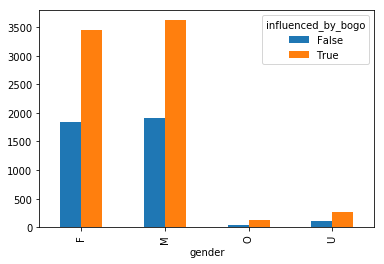

In [119]:
pd.pivot_table(bogo_inf_transactions, index=['gender'], columns=['influenced_by_bogo'], values=['person'], aggfunc=lambda x: len(x.unique())).plot.bar(y='person')


About twice the people (unique persons) who received the bogo offers were influenced by the bogo offers.
The distribution between males and females are equal. Both groups are equally influenced by bogo offers.
Same observation can be said about the other (O) group and the unspecified (U) group.

### Total transactions by gender 

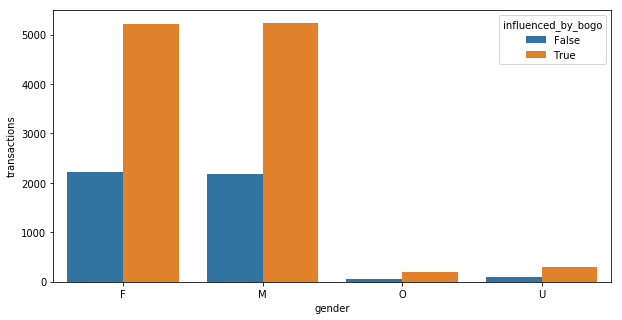

In [120]:
data = (bogo_inf_transactions.groupby(['gender', 'influenced_by_bogo'])['person']
    .count().reset_index().rename(columns={'person': 'transactions'}))
plotbars(x='gender', y='transactions', hue='influenced_by_bogo', data=data)

The number of transactions between males and females are equally influenced. In all gender groups, the transactions that were influenced are roughly twice as many as the ones that were not influenced.

### Average amount spent by gender

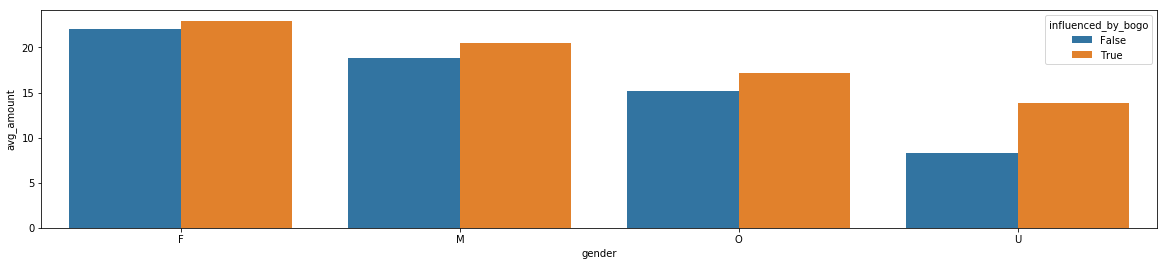

In [121]:
data = bogo_inf_transactions.groupby(['gender', 'influenced_by_bogo'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='gender', y='avg_amount', hue='influenced_by_bogo', data=data, figsize=(20,4))

The groups that were influenced spent slightly higher on average. In the unspecified gender group (U), those who were influenced spent almost twice as much on average as those who were not influenced. 

### Total transactions by age bracket

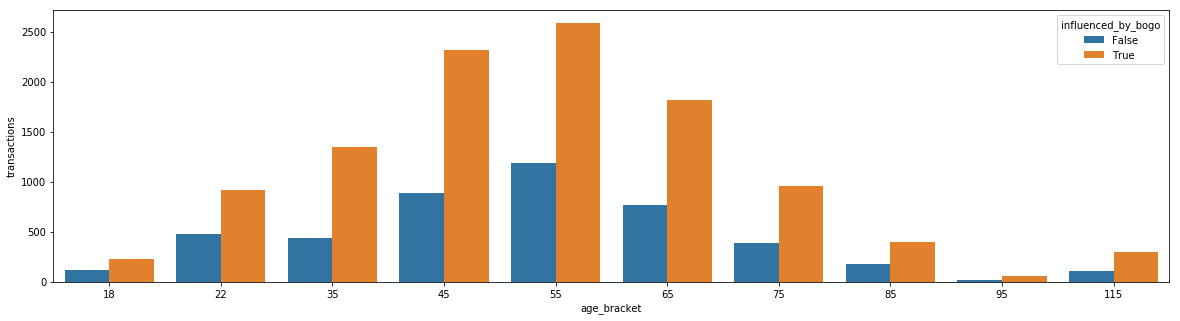

In [122]:
data = bogo_inf_transactions.groupby(['age_bracket', 'influenced_by_bogo'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='age_bracket', y='transactions', hue='influenced_by_bogo', data=data, figsize=(20,5))

Plot shows that bogo offers had an influenced on transactions. There are more influenced transactions than not influenced transactions.

For each age bracket, the number bogo influenced transactions is roughly twice the number of not-influenced transactions, in some cases more than twice.


### Average amount spent by age bracket

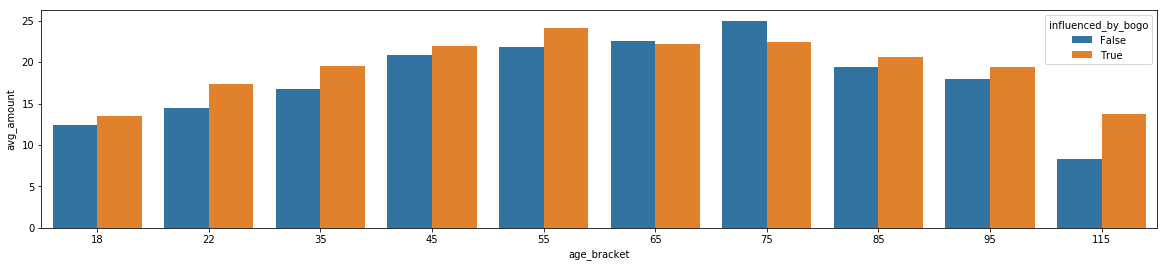

In [123]:
data = bogo_inf_transactions.groupby(['age_bracket', 'influenced_by_bogo'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='age_bracket', y='avg_amount', hue='influenced_by_bogo', data=data, figsize=(20,4))

The average amount spent by those who are influenced are generally higher than those who are not influenced. For age bracket 75, average spent by those who are not influenced is higher.

### Total transactions by income bracket

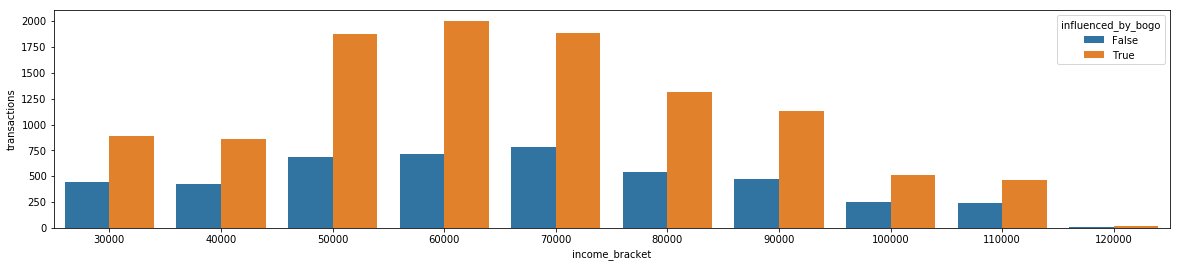

In [124]:
data = bogo_inf_transactions.groupby(['income_bracket', 'influenced_by_bogo'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='income_bracket', y='transactions', hue='influenced_by_bogo', data=data, figsize=(20,4))

Plot shows that bogo offers had an influenced on transactions. There are influenced transactions than not influenced transactions.

### Average amount spent by income bracket


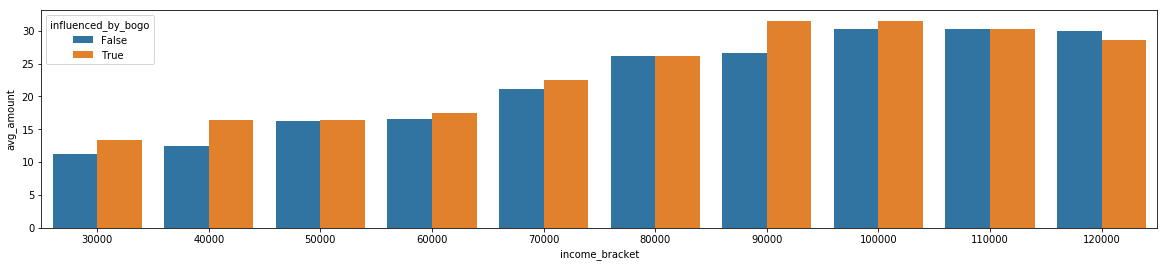

In [125]:
data = bogo_inf_transactions.groupby(['income_bracket', 'influenced_by_bogo'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='income_bracket', y='avg_amount', hue='influenced_by_bogo', data=data, figsize=(20,4))

The average amount spent by those who are influenced are only higher for some income brackets. People who are in \\$30K, \\$40K, \\$90K bracket spent more on average with the bogo . People who are in \\$120K bracket spent more on average spent more without the bogo.

## Influence of Discount Offers


In [126]:
discount_inf_transactions = transactions[transactions['influenced_by_discount'].notna()]

In [127]:
discount_inf_transactions.shape[0]

17681

### Number of people by gender

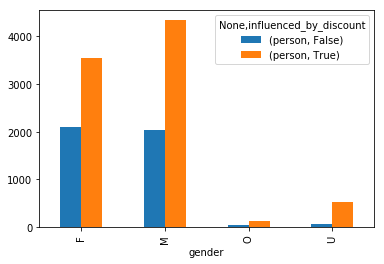

In [128]:
pd.pivot_table(discount_inf_transactions, index=['gender'], columns=['influenced_by_discount'], values=['person'], aggfunc=lambda x: len(x.unique())).plot.bar()

More than twice the people (unique persons) who received discount offers were influenced by the offers. 
More males responded than female, although there are more males than females.
All groups responded well to discount offers.

### Total transactions by gender 


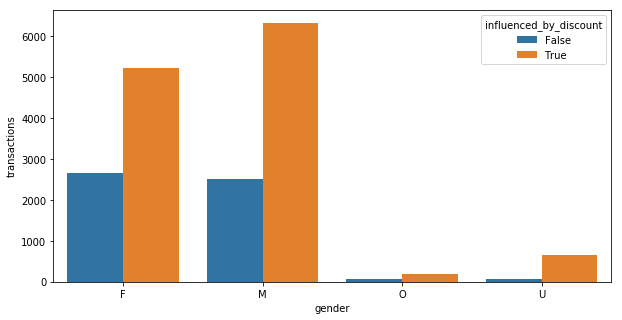

In [129]:
data = discount_inf_transactions.groupby(['gender', 'influenced_by_discount'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='gender', y='transactions', hue='influenced_by_discount', data=data)

Corresponding the previous plot, we see more transactions from males due to the higher male population than female population. All groups responded well to discount offers.

### Average amount spent by gender


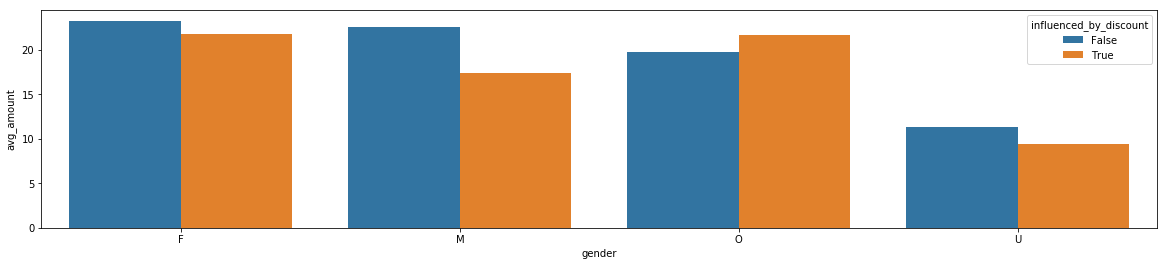

In [130]:
data = discount_inf_transactions.groupby(['gender', 'influenced_by_discount'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='gender', y='avg_amount', hue='influenced_by_discount', data=data, figsize=(20,4))

The average spend among those who responded to the offers are generally lower. We can argue that those who responded well to discount offers are money-conscious about their spending and heavily took advantage of the discounts rewarded by the offers to help them saved more money than those are not as money-conscious (those who spent anyway but did not care about the discount).

### Total transactions by age bracket

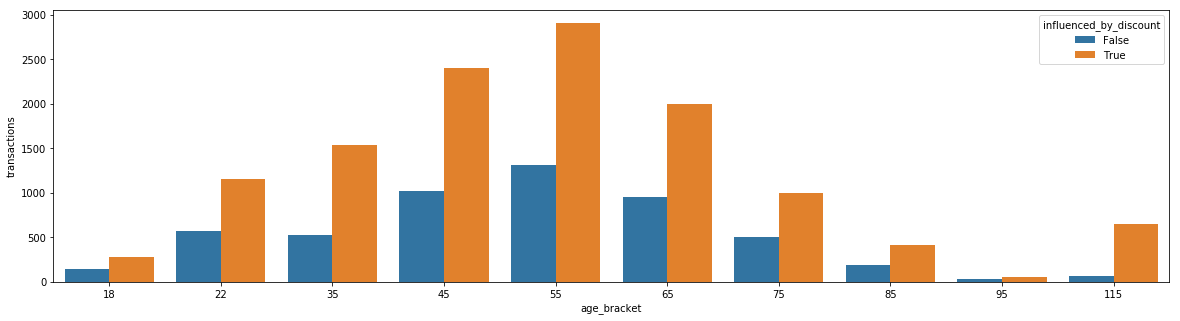

In [131]:
data = discount_inf_transactions.groupby(['age_bracket', 'influenced_by_discount'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='age_bracket', y='transactions', hue='influenced_by_discount', data=data, figsize=(20,5))

We can see a heavy influence of discount offers. There are more transactions that responded in all age brackets.

### Average amount spent by age bracket

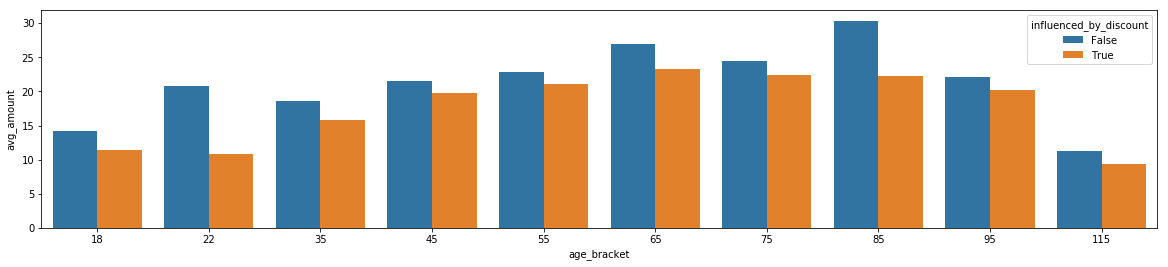

In [132]:
data = discount_inf_transactions.groupby(['age_bracket', 'influenced_by_discount'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='age_bracket', y='avg_amount', hue='influenced_by_discount', data=data, figsize=(20,4))

Again, average spends by those who responded are lower. I assert that money-conscious buyers heavily took advantage of the discounts - this correlates to the higher number discounted transactions made by those who responded vs those who did not respond, shown in the previous plot.

### Total transactions by income bracket 


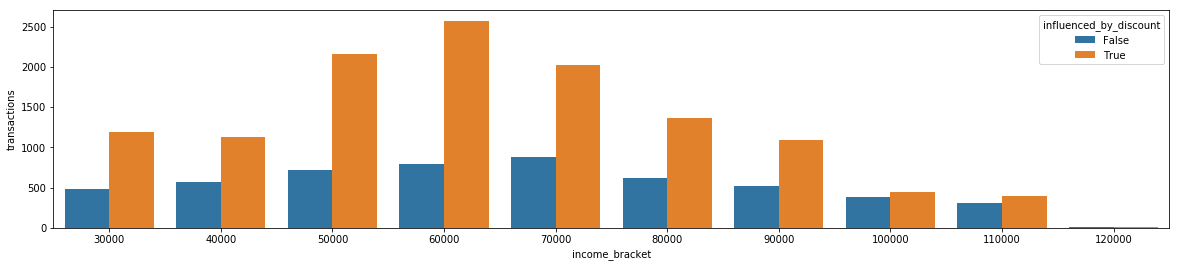

In [133]:
data = discount_inf_transactions.groupby(['income_bracket', 'influenced_by_discount'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='income_bracket', y='transactions', hue='influenced_by_discount', data=data, figsize=(20,4))

We can see a heavy influence of discount offers. There are more transactions that responded in most income brackets, except those are in \\$100K and above brackets.

### Average amount spent by income bracket

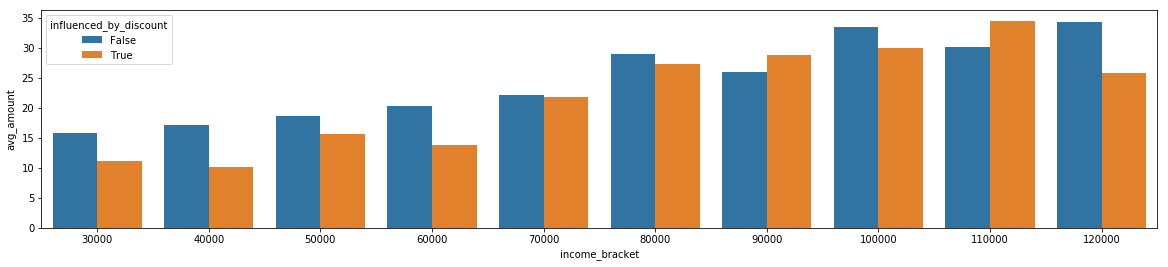

In [134]:
data = discount_inf_transactions.groupby(['income_bracket', 'influenced_by_discount'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='income_bracket', y='avg_amount', hue='influenced_by_discount', data=data, figsize=(20,4))

Align with what we observed previously, those didn't respond (those who would spend without the offers) have a higher average spend - suggesting that this group didn't go into the store to buy because of discounts.

## Influence of Informational Offers

In [135]:
info_inf_transactions = transactions[transactions['influenced_by_info'].notna()]

In [136]:
info_inf_transactions.shape[0]

53043

### Number of people by gender

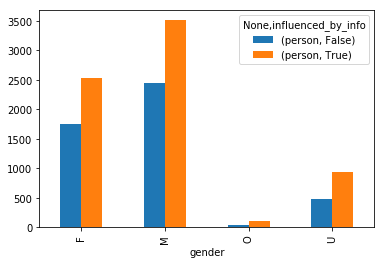

In [137]:
pd.pivot_table(info_inf_transactions, index=['gender'], columns=['influenced_by_info'], values=['person'], aggfunc=lambda x: len(x.unique())).plot.bar()

Compare to discount and bogo offers, a smaller percentage of people responded to informational offer. This observation is true for all gender groups.

### Total transactions by gender 

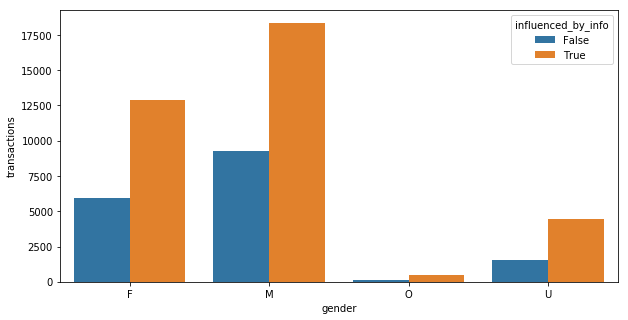

In [138]:
data = info_inf_transactions.groupby(['gender', 'influenced_by_info'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='gender', y='transactions', hue='influenced_by_info', data=data)

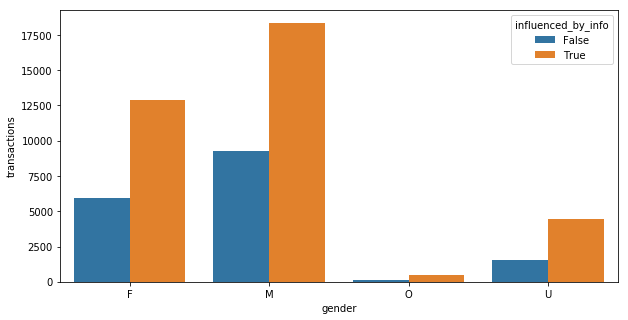

In [139]:
data = info_inf_transactions.groupby(['gender', 'influenced_by_info'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='gender', y='transactions', hue='influenced_by_info', data=data)

For all gender groups, there are more influenced transactions than no influenced transactions.

### Average amount spent by gender

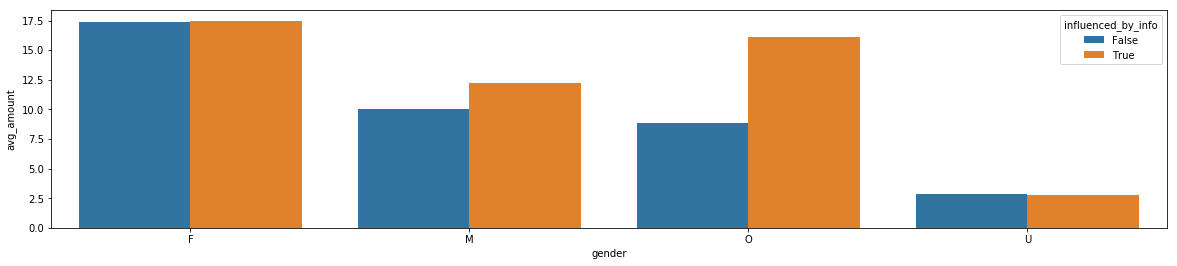

In [140]:
data = info_inf_transactions.groupby(['gender', 'influenced_by_info'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='gender', y='avg_amount', hue='influenced_by_info', data=data, figsize=(20,4))

Average spend by those who are influenced (responded) are higher than those who are not among males and others.

### Total transactions by age bracket


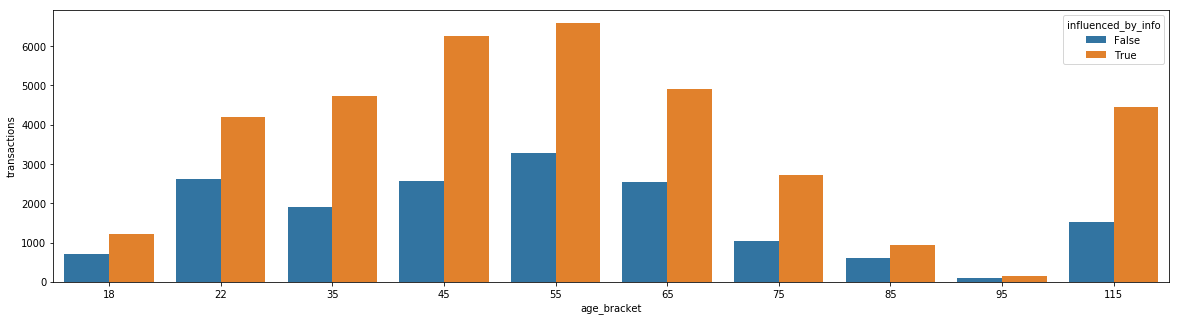

In [141]:
data = info_inf_transactions.groupby(['age_bracket', 'influenced_by_info'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='age_bracket', y='transactions', hue='influenced_by_info', data=data, figsize=(20,5))

Plot shows the influence of informational offers where there are more transactions made by people who saw the information.

### Average amount spent by age bracket

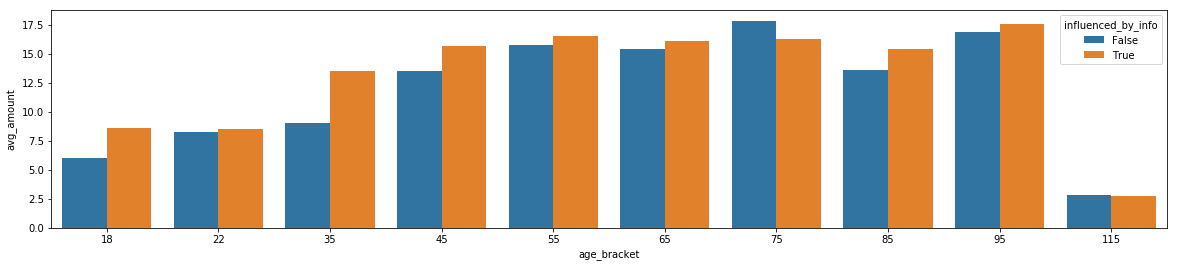

In [142]:
data = info_inf_transactions.groupby(['age_bracket', 'influenced_by_info'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='age_bracket', y='avg_amount', hue='influenced_by_info', data=data, figsize=(20,4))

The average spend by those who are influenced varies by age bracket.

### Total transactions by income bracket 

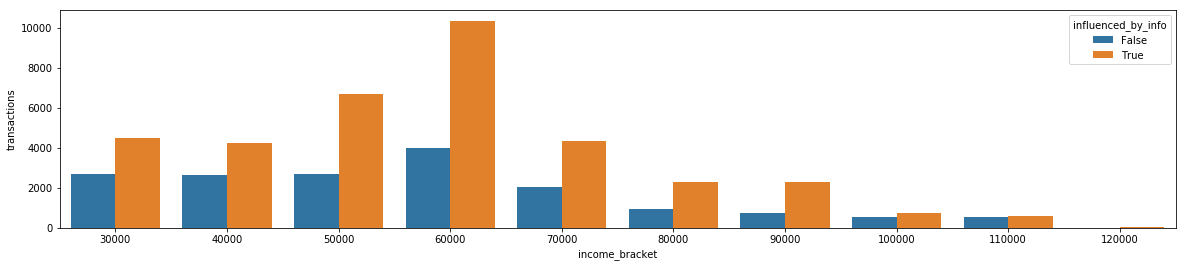

In [143]:
data = info_inf_transactions.groupby(['income_bracket', 'influenced_by_info'])['person'].count().reset_index().rename(columns={'person': 'transactions'})
plotbars(x='income_bracket', y='transactions', hue='influenced_by_info', data=data, figsize=(20,4))


Plot shows the influence of informational offers on income brackets. There are more transactions made by people who saw the information. Those who make $100k or above are not influenced.

### Average amount spent by income bracket

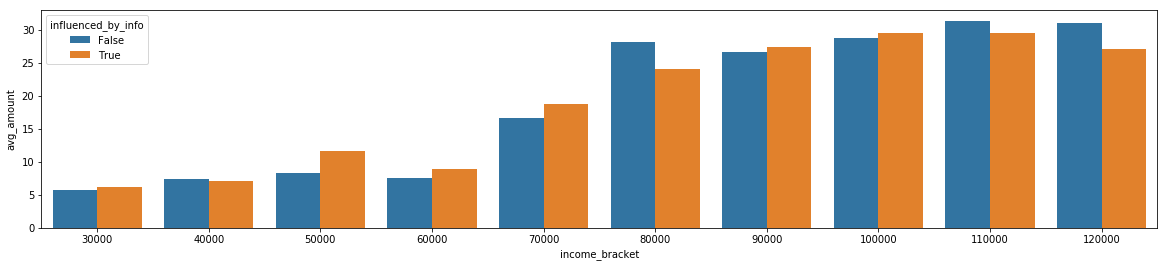

In [144]:

data = info_inf_transactions.groupby(['income_bracket', 'influenced_by_info'])['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
plotbars(x='income_bracket', y='avg_amount', hue='influenced_by_info', data=data, figsize=(20,4))

The average spend by those who are influenced varies by age bracket.

## Observation

A couple of important points to reiterate.

We just learned many people responded well to both reward offers and informational offers. We see this general pattern for all gender, age brackets and income brackets. However, it's difficult to visualize which offers have a higher response.

The average spend varies from group to group, by gender, income, and age.


# Checking the rate of completion

#### Question: Which offers have better response rate?

In [145]:
data = transactions[[
    'offer_id', 'age', 'gender', 'age_bracket', 'income_bracket', 'influenced_by_info',
       'influenced_by_bogo', 'influenced_by_discount', 'amount']]

data['influenced_by_none'] = (data['influenced_by_info'].isna() & data['influenced_by_bogo'].isna() & data['influenced_by_discount'].isna())


# Recall that there are three states to influenced. true/false and na for not received. Explicitly create
# a column for received.
data['received_info_offer'] = data['influenced_by_info'].notna().astype('int')
data['received_bogo_offer'] = data['influenced_by_bogo'].notna().astype('int')
data['received_discount_offer'] = data['influenced_by_discount'].notna().astype('int')

data['influenced_by_info'].fillna(False, inplace=True)
data['influenced_by_bogo'].fillna(False, inplace=True)
data['influenced_by_discount'].fillna(False, inplace=True)
data['influenced_by_none'].fillna(False, inplace=True)

data['influenced_by_info'] = data['influenced_by_info'].astype('int')
data['influenced_by_bogo'] = data['influenced_by_bogo'].astype('int')
data['influenced_by_discount'] = data['influenced_by_discount'].astype('int')
data['influenced_by_none'] = data['influenced_by_none'].astype('int')


/sdk/install/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/sdk/install/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/sdk/install/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [146]:
data.head()

,offer_id,age,gender,age_bracket,income_bracket,influenced_by_info,influenced_by_bogo,influenced_by_discount,amount,influenced_by_none,received_info_offer,received_bogo_offer,received_discount_offer
0,NaN,20,F,18,30000,0,0,0,0.83,1,0,0,0
1,2906b810c7d4411798c6938adc9daaa5,42,M,35,90000,0,0,1,34.56,0,0,0,1
2,NaN,36,M,35,50000,0,0,0,13.23,1,0,0,0
3,NaN,55,F,55,90000,0,0,0,19.51,1,0,0,0
4,fafdcd668e3743c1bb461111dcafc2a4,39,F,35,60000,0,0,0,18.97,0,0,0,1


In [147]:
data = data[['age', 'gender', 'age_bracket', 'income_bracket', 
                   'received_info_offer', 'influenced_by_info',
                   'received_bogo_offer', 'influenced_by_bogo',
                   'received_discount_offer', 'influenced_by_discount', 
                   'influenced_by_none', 'amount']]
data.groupby(['age', 'gender']).sum().sort_values('influenced_by_none', ascending=False).head(4)
data = data.groupby(['age', 'gender', 'age_bracket', 'income_bracket']).sum().sort_values('influenced_by_info', ascending=False)
data['response_rate_to_info'] = data['influenced_by_info'].astype('float') / data['received_info_offer']
data['response_rate_to_bogo'] = data['influenced_by_bogo'].astype('float') / data['received_bogo_offer']
data['response_rate_to_discount'] = data['influenced_by_discount'].astype('float') / data['received_discount_offer']
data.fillna(0, inplace=True)


#### Question: What is the rate of completion for offer type?


In [148]:
data[['response_rate_to_info', 
      'response_rate_to_bogo', 'response_rate_to_discount']].head(3)

,,,,response_rate_to_info,response_rate_to_bogo,response_rate_to_discount
age,gender,age_bracket,income_bracket,,,
118,U,115,60000,0.744859,0.733167,0.912799
37,M,35,60000,0.810345,0.916667,0.739130
53,M,45,50000,0.869281,0.743590,0.971429


In [149]:
data[['response_rate_to_info', 
      'response_rate_to_bogo', 'response_rate_to_discount']].describe()

,response_rate_to_info,response_rate_to_bogo,response_rate_to_discount
count,1399.000000,1399.000000,1399.000000
mean,0.608385,0.658467,0.648096
std,0.322374,0.276680,0.277537
min,0.000000,0.000000,0.000000
25%,0.432576,0.555556,0.521164
50%,0.671053,0.700000,0.687500
75%,0.866667,0.833333,0.833333
max,1.000000,1.000000,1.000000


The average response rate is 0.60 for informational offer, 0.66 for bogo and 0.65 for discount.